In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
%matplotlib inline

from dataset import MAESTRO_small
from constants import HOP_SIZE

## Visulize GT test samples

Use test

In [2]:
test_dataset = MAESTRO_small(path='../data', groups=['test'], random_sample=False)

Loading 1 group(s) of MAESTRO_small at ../data


Loading group test: 100%|██████████| 50/50 [00:11<00:00,  4.51it/s]


In [3]:
for i in range(len(test_dataset)):
    data = test_dataset[i]
    print(f'data {i}: {data["path"]}')

data 0: ../data/2004/MIDI-Unprocessed_SMF_17_R1_2004_03-06_ORIG_MID--AUDIO_20_R2_2004_12_Track12_wav--1.flac
data 1: ../data/2004/MIDI-Unprocessed_XP_04_R1_2004_03-05_ORIG_MID--AUDIO_04_R1_2004_06_Track06_wav.flac
data 2: ../data/2006/MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_02_Track02_wav.flac
data 3: ../data/2006/MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_04_Track04_wav.flac
data 4: ../data/2006/MIDI-Unprocessed_03_R1_2006_01-05_ORIG_MID--AUDIO_03_R1_2006_04_Track04_wav.flac
data 5: ../data/2006/MIDI-Unprocessed_07_R1_2006_01-04_ORIG_MID--AUDIO_07_R1_2006_04_Track04_wav.flac
data 6: ../data/2006/MIDI-Unprocessed_24_R1_2006_01-05_ORIG_MID--AUDIO_24_R1_2006_03_Track03_wav.flac
data 7: ../data/2008/MIDI-Unprocessed_04_R1_2008_01-04_ORIG_MID--AUDIO_04_R1_2008_wav--4.flac
data 8: ../data/2008/MIDI-Unprocessed_04_R3_2008_01-07_ORIG_MID--AUDIO_04_R3_2008_wav--3.flac
data 9: ../data/2008/MIDI-Unprocessed_04_R3_2008_01-07_ORIG_MID--AUDIO_04_R3_2008_wav--6

In [12]:
data = test_dataset[4]
print(f'data path: {data["path"]}')
print(f'audio_shape: {data["audio"].shape}')
print(f'frame_roll_shape: {data["frame"].shape}')
print(f'onset_roll_shape: {data["onset"].shape}')

data path: ../data/2006/MIDI-Unprocessed_03_R1_2006_01-05_ORIG_MID--AUDIO_03_R1_2006_04_Track04_wav.flac
audio_shape: torch.Size([15086592])
frame_roll_shape: torch.Size([29466, 88])
onset_roll_shape: torch.Size([29466, 88])


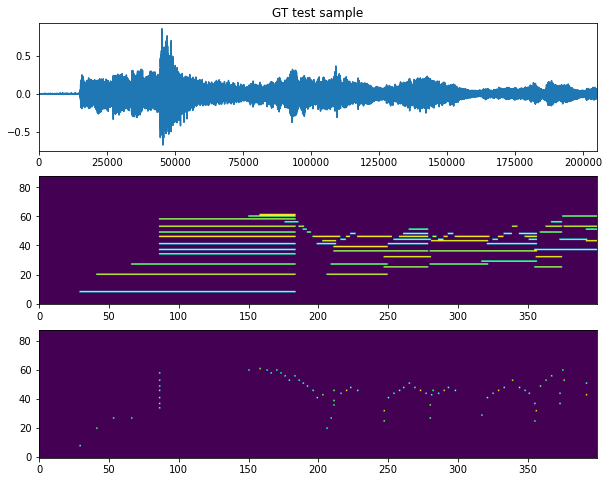

In [13]:
plt.figure(figsize=(10,8))
plt.subplot(311).set_title('GT test sample')
plt.plot(data['audio'].numpy()[:400*HOP_SIZE])
plt.autoscale(enable=True, axis='x', tight=True)
plt.subplot(312)
plt.imshow(data['frame'].numpy()[:400].T, aspect='auto', origin='lower')
plt.subplot(313)
plt.imshow(data['onset'].numpy()[:400].T, aspect='auto', origin='lower')


## Visualize prediction results

Use debug

In [4]:
import pretty_midi
import soundfile
import torch
import numpy as np
import glob


SAMPLE_RATE = 16000
MIN_MIDI = 21
MAX_MIDI = 108

HOP_SIZE = 512
N_MELS = 229
N_FFT = 2048
F_MIN = 30
F_MAX = 8000


In [5]:
def load(audio_path, midi_path):
    """Loads an audio track and the corresponding labels."""
    audio, sr = soundfile.read(audio_path, dtype='int16')
    assert sr == SAMPLE_RATE
    frames_per_sec = sr / HOP_SIZE

    audio = torch.ShortTensor(audio)
    audio_length = len(audio)

    mel_length = audio_length // HOP_SIZE + 1

    midi = pretty_midi.PrettyMIDI(midi_path)
    midi_length_sec = midi.get_end_time()
    frame_length = min(int(midi_length_sec * frames_per_sec), mel_length)

    audio = audio[:frame_length * HOP_SIZE]
    frame = midi.get_piano_roll(fs=frames_per_sec)
    onset = np.zeros_like(frame)
    for inst in midi.instruments:
        for note in inst.notes:
            onset[note.pitch, int(note.start * frames_per_sec)] = 1

    # to shape (time, pitch (88))
    frame = torch.from_numpy(frame[MIN_MIDI:MAX_MIDI + 1].T)
    onset = torch.from_numpy(onset[MIN_MIDI:MAX_MIDI + 1].T)
    data = dict(path=audio_path, audio=audio, frame=frame, onset=onset)
    return data

In [14]:
midi_files = sorted(glob.glob("".join(['../runs/onf/', '*.midi'])))
wav_files = sorted(glob.glob("".join(['../runs/onf/', '*.wav'])))

assert len(midi_files) == len(wav_files) and len(midi_files) != 0, 'no files'

for i in range(len(midi_files)):
    file = midi_files[i]
    print(f'data {i}: {file}')
    

data 0: ../runs/onf/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--1.midi
data 1: ../runs/onf/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--2.midi
data 2: ../runs/onf/MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_09_R1_2014_wav--4.midi
data 3: ../runs/onf/MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_11_R1_2014_wav--1.midi
data 4: ../runs/onf/MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_13_R1_2014_wav--6.midi
data 5: ../runs/onf/MIDI-UNPROCESSED_19-21_R3_2014_MID--AUDIO_21_R3_2014_wav--1.midi
data 6: ../runs/onf/MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_02_Track02_wav.midi
data 7: ../runs/onf/MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_04_Track04_wav.midi
data 8: ../runs/onf/MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_04_WAV.midi
data 9: ../runs/onf/MIDI-Unprocessed_02_R1_2011_MID--AUDIO_R1-D1_10_Track10_wav.midi
data 10: ../runs/onf/MIDI-Unprocessed_03_R1_2006_01-05_ORIG_MID--AUDIO_03_R1_2006_04_Track04_wav.mi

In [21]:
crnn_midi_files = sorted(glob.glob("".join(['../runs/crnn/', '*.midi'])))
crnn_wav_files = sorted(glob.glob("".join(['../runs/crnn/', '*.wav'])))

win_midi_files = sorted(glob.glob("".join(['../runs/onf_win1024/', '*.midi'])))
win_wav_files = sorted(glob.glob("".join(['../runs/onf_win1024/', '*.wav'])))



In [22]:
data = load(wav_files[10], midi_files[10])
crnn_data = load(crnn_wav_files[10], crnn_midi_files[10])
win_data = load(win_wav_files[10], win_midi_files[10])
print(f'data path: {data["path"]}')
print(f'data path: {crnn_data["path"]}')
print(f'audio_shape: {data["audio"].shape}')
print(f'frame_roll_shape: {data["frame"].shape}')
print(f'onset_roll_shape: {data["onset"].shape}')

data path: ../runs/onf/MIDI-Unprocessed_03_R1_2006_01-05_ORIG_MID--AUDIO_03_R1_2006_04_Track04_wav.wav
data path: ../runs/crnn/MIDI-Unprocessed_03_R1_2006_01-05_ORIG_MID--AUDIO_03_R1_2006_04_Track04_wav.wav
audio_shape: torch.Size([15085056])
frame_roll_shape: torch.Size([29463, 88])
onset_roll_shape: torch.Size([29463, 88])


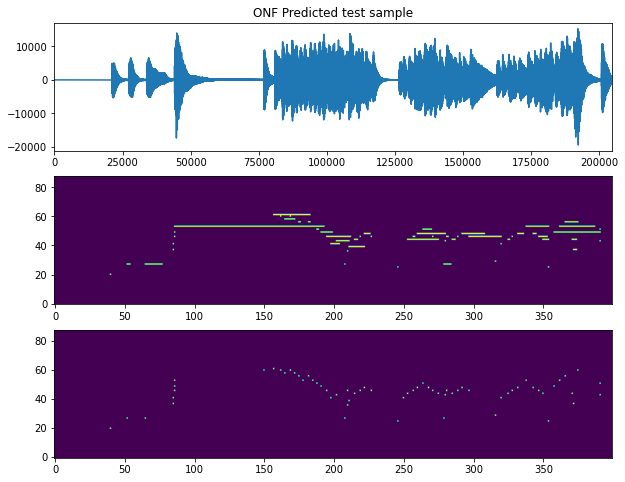

In [19]:
plt.figure(figsize=(10,8))
plt.subplot(311).set_title('ONF Predicted test sample')
plt.plot(data['audio'].numpy()[:400*HOP_SIZE])
plt.autoscale(enable=True, axis='x', tight=True)
plt.subplot(312)
plt.imshow(data['frame'].numpy()[:400].T, aspect='auto', origin='lower')
plt.subplot(313)
plt.imshow(data['onset'].numpy()[:400].T, aspect='auto', origin='lower')

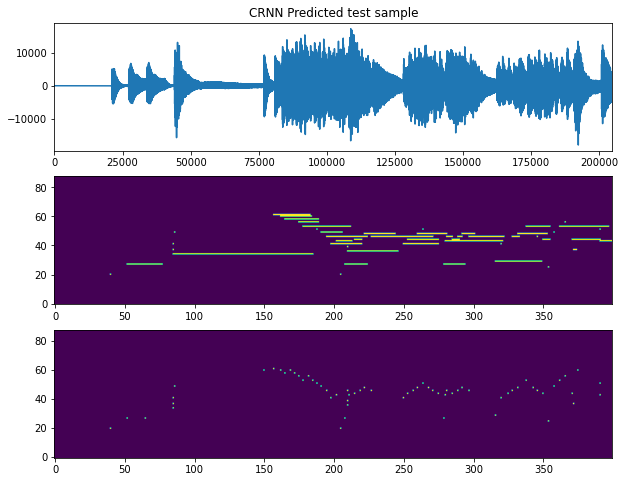

In [20]:
plt.figure(figsize=(10,8))
plt.subplot(311).set_title('CRNN Predicted test sample')
plt.plot(crnn_data['audio'].numpy()[:400*HOP_SIZE])
plt.autoscale(enable=True, axis='x', tight=True)
plt.subplot(312)
plt.imshow(crnn_data['frame'].numpy()[:400].T, aspect='auto', origin='lower')
plt.subplot(313)
plt.imshow(crnn_data['onset'].numpy()[:400].T, aspect='auto', origin='lower')

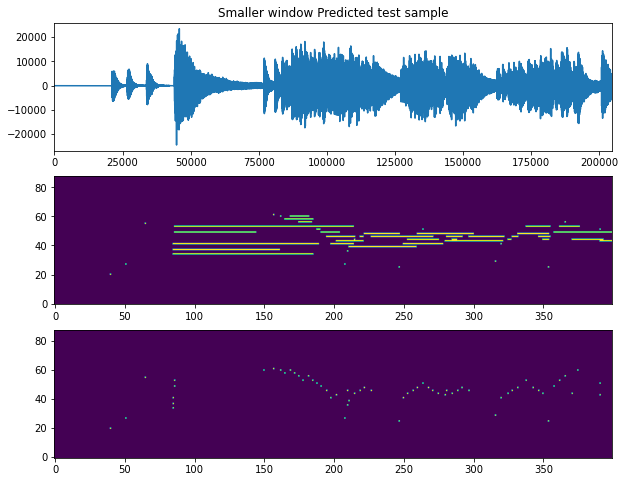

In [24]:
plt.figure(figsize=(10,8))
plt.subplot(311).set_title('Smaller window Predicted test sample')
plt.plot(win_data['audio'].numpy()[:400*HOP_SIZE])
plt.autoscale(enable=True, axis='x', tight=True)
plt.subplot(312)
plt.imshow(win_data['frame'].numpy()[:400].T, aspect='auto', origin='lower')
plt.subplot(313)
plt.imshow(win_data['onset'].numpy()[:400].T, aspect='auto', origin='lower')

In [ ]:
# CRNN, ONF 비교: data[4], data[10]
# 빠른거 한 쌍: data[29], files[46]
# 느린거 한 쌍: data[49], files[42] 